# Lab: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


In [ ]:
# To use it in colab, update spacy
# !pip install --upgrade spacy

In [ ]:
# Download language model
# !python -m spacy download en_core_web_md

In [ ]:
import numpy as np
import pandas as pd
import spacy
from torch import nn
from torch import optim
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Neural_Networks/P3/Sentences.txt"
with open(file_path, "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [ ]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


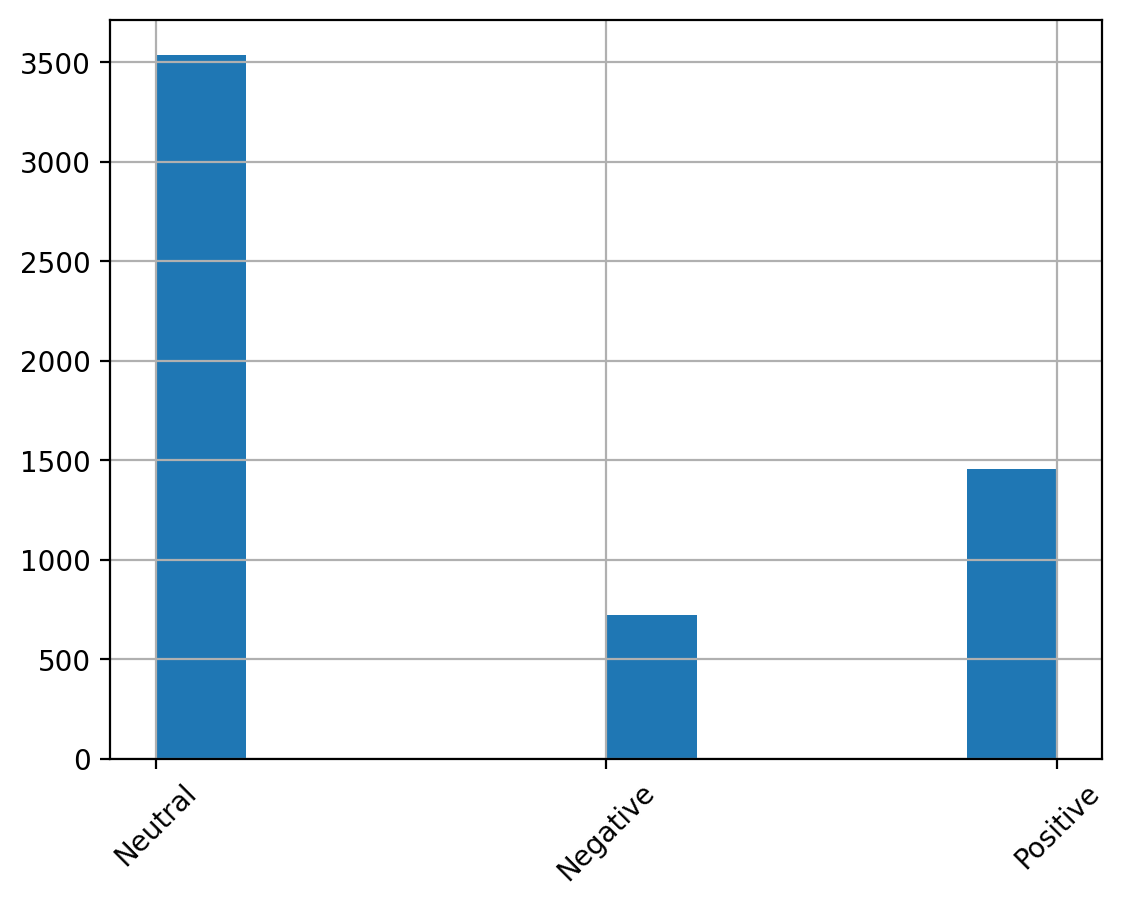

In [ ]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()

In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

#**Text pre-processing**

In [ ]:
nlp = spacy.load("en_core_web_md") # Language model

docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop and w.pos_ in {"ADJ", "ADV", "VERB", "NOUN"}]

norm_docs = [normalize(d) for d in docs]

In [ ]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [ ]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [[garbage_token] *(max_l-lengths[d]) + norm_docs[d] for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

#**Import Recurrent Neural Network**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):


        super().__init__()

        self.hidden_dim = hidden_dim

        self.input_size = input_size

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, dropout=prob)

        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Capa dropout

        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):

        '''

        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify

        '''

        batch_size = x.size(0)
        seq_length = x.size(1)

        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ =  self.rnn(x)

        # Now it comes the tricky part. You have to stack in a (batch_size, hidden_dim) tensor, the right state
        # for each sequece. Namely, the state after processing the last real token (not the junk # ones)
        # The function torch.stack() can be handy

        aux = torch.stack([r_out[d, lengths[d] - 1, :] for d in range(batch_size)]).reshape([-1, self.hidden_dim])

        # We classify using such tensor (don't forget the dropout!)

        output = self.logsoftmax(self.fc1(self.dropout(aux)))


        return output

In [ ]:
class RNN_with_train(RNN):

    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):

        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)

        self.lr = lr # Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.batch_size = batch_size

        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):

        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():

            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            logprobs = self.forward(x_input,[len(d) for d in docs]).detach().numpy()

            if(len(Y)>0):

                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):

        '''
        Método de entrenamiento.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''

        self.print_every = print_every

        self.epochs=epochs

        # Optimization Loop

        self.num_train = len(docs_train) # Number of training points

        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches

        self.num_val = len(docs_val) # Number of validation points

        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels

        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels


        for e in range(int(self.epochs)):

            self.train() # Activate dropout

            # Random data permutation

            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings

                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data

                out = self.forward(x_input,[len_train[d] for d in idx_batch])

                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps

                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                idx = np.random.permutation(self.num_val)

                running_loss = 0.

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]

                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)



            if(e % self.print_every == 0):

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

# **Implement Attention**

In [ ]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.W1 = nn.Linear(hidden_dim * 2, hidden_dim)  # First layer of MLP: It takes an input concatenation of query and key
        self.W2 = nn.Linear(hidden_dim, 1)  # Second layer to produce scalar weights. Ouputs the unnormalized attention weight

    def forward(self, rnn_outputs, last_hidden, mask):
        """
        rnn_outputs: output of the RNN for each time step (batch_size, seq_len, hidden_dim)
        last_hidden: hidden state of the RNN at last time step (batch_size, hidden_dim)
        mask: (batch_size, seq_len) - binary mask for valid positions
        """
        batch_size, seq_len, _ = rnn_outputs.shape # dim of the rnn outputs

        query = last_hidden.unsqueeze(1).expand(-1, seq_len, -1)

        combined = torch.cat((query, rnn_outputs), dim=2) # query and key are concatenated

        scores = self.W2(torch.tanh(self.W1(combined))).squeeze(-1)

        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=1)

        context = torch.sum(attn_weights.unsqueeze(-1) * rnn_outputs, dim=1)

        return context, attn_weights


In [ ]:
class RNN_with_Attention(RNN_with_train):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5, batch_size=50, lr=0.0005, saved_files='./saved_models'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob, batch_size, lr, saved_files)
        self.attention = Attention(hidden_dim)  # Add the attention layer

    def forward(self, x, lengths, h0=None):
        batch_size = x.size(0)
        seq_length = x.size(1)

        # RNN output (sequence of hidden states)
        r_out, _ = self.rnn(x)

        # Mask for valid tokens (excluding garbage tokens)
        mask = (x.sum(dim=-1) != 0).float()

        # Last hidden state used as query for attention
        aux = torch.stack([r_out[d, lengths[d] - 1, :] for d in range(batch_size)]).reshape([-1, self.hidden_dim])

        # Apply attention mechanism
        context, attn_weights = self.attention(r_out, aux, mask)

        # Final classification
        output = self.logsoftmax(self.fc1(self.dropout(context)))

        return output


In [ ]:
my_RNN = RNN_with_Attention(input_size=300,output_size=2,hidden_dim=20,n_layers=1, prob=0.3)

# Call train
my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
<ipython-input-31-08213e3f274d>:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])


Training loss after 0 epochs: 0.4396821895282563. Validation loss: 0.3646729936202367
Training loss after 1 epochs: 0.3897715151718218. Validation loss: 0.35720810294151306
Training loss after 2 epochs: 0.38040648155832946. Validation loss: 0.3434862875276142
Training loss after 3 epochs: 0.3733086947300663. Validation loss: 0.3440380071600278
Training loss after 4 epochs: 0.3650836562865401. Validation loss: 0.3318885895940993
Training loss after 5 epochs: 0.3554705840675798. Validation loss: 0.3185930997133255
Training loss after 6 epochs: 0.3436254618102557. Validation loss: 0.31565404848919976
Training loss after 7 epochs: 0.3393351607126732. Validation loss: 0.31353889488511616
Training loss after 8 epochs: 0.3293213276830438. Validation loss: 0.30315744711293113
Training loss after 9 epochs: 0.31897125852434605. Validation loss: 0.29879821091890335
Training loss after 10 epochs: 0.31292671996028454. Validation loss: 0.29353273825512993
Training loss after 11 epochs: 0.30363716491

Text(0.5, 1.0, 'Training for LSTM without Attention')

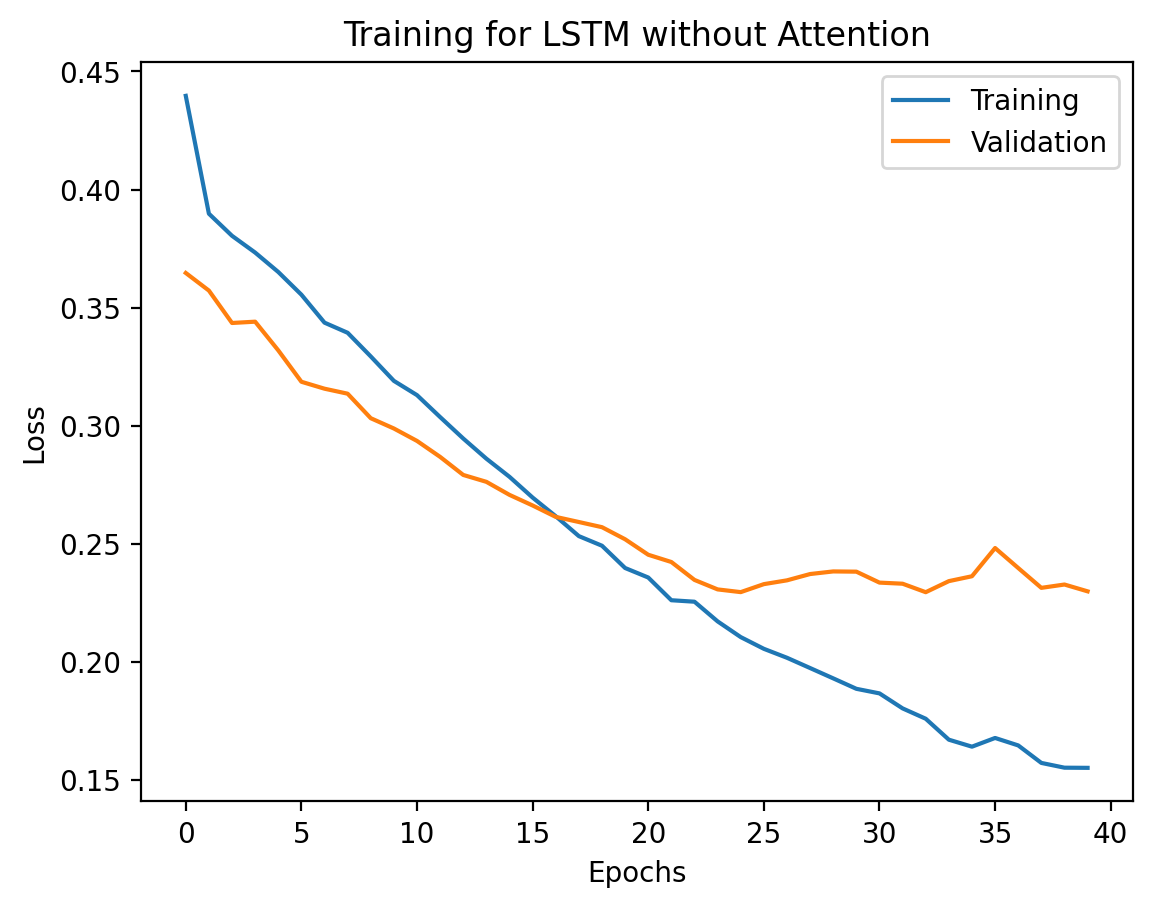

In [ ]:
# Plotting the train/val loss
plt.figure()
plt.plot(my_RNN.loss_during_training, label='Training')
plt.plot(my_RNN.valid_loss_during_training, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training for LSTM without Attention')

In [ ]:
idx_min = np.argsort(my_RNN.valid_loss_during_training)
my_RNN.load_state_dict(torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

In [ ]:
logprobs,acc = my_RNN.predict_proba(docs_test, len_test, y_test)

probs = np.exp(logprobs)

print(f"The test accuracy is {acc}")

The test accuracy is 0.9125874125874126


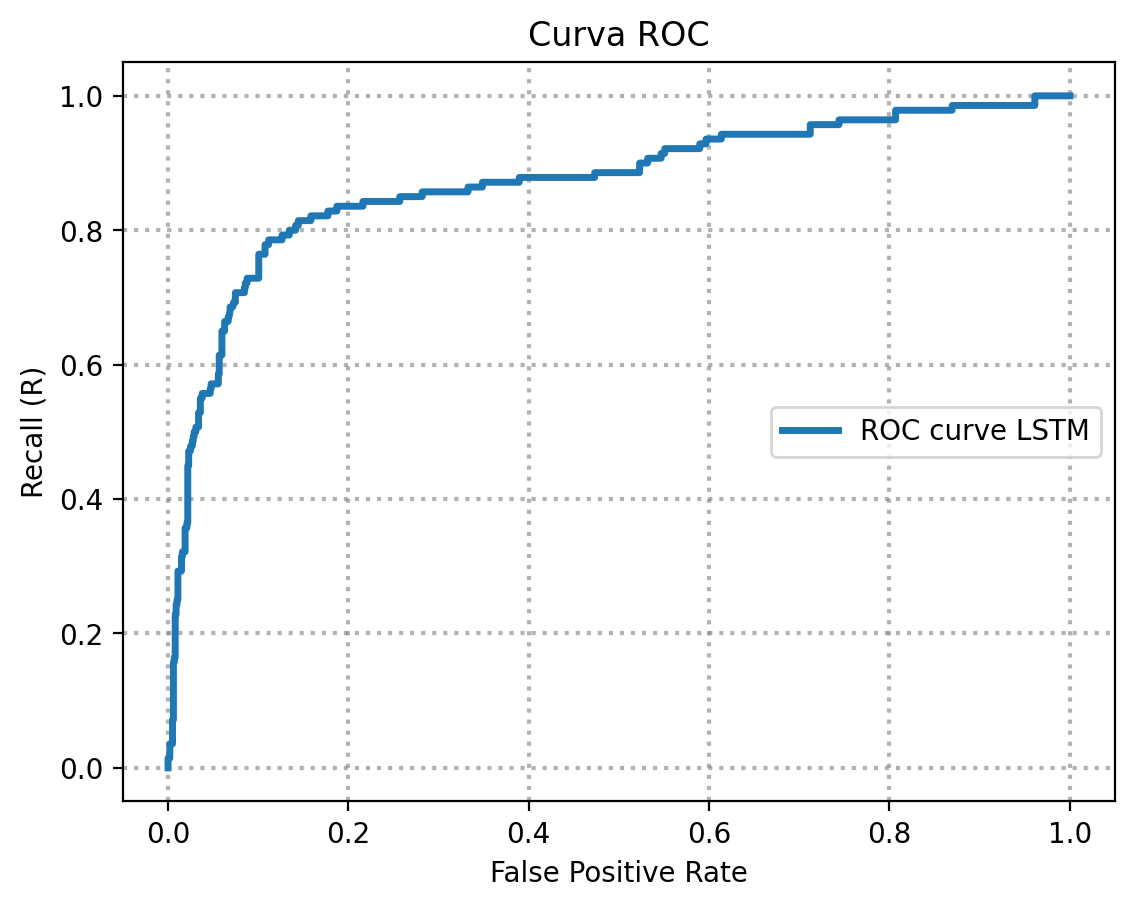

AUC ROC for LSTM is 0.8717344906089928


In [ ]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

In [ ]:
attn_weights = my_RNN.attention.W2.weight.detach().numpy() # Access attn_weights through the attention attribute and W2 layer.
outputs = my_RNN.fc1.weight.detach().numpy()# Access outputs weights through the fc1 layer.

In [ ]:
docs_to_visualize = []
for i in range(20, 100):  # Check the first 10 samples, adjust as needed
    words = [token.text for token in docs_test[i] if token.text != '#']
    sentiment = 'Negative' if y_test[i] == 1 else 'Positive'
    docs_to_visualize.append((i, words, sentiment))

docs_to_visualize


[(20,
  ['European',
   'brokers',
   'recommendations',
   'issued',
   'today',
   'collated',
   'range',
   'market',
   'sources'],
  'Positive'),
 (21, ['Cargo', 'volume', 'grew'], 'Positive'),
 (22,
  ['Finnish',
   'electronics',
   'contract',
   'manufacturer',
   'net',
   'sales',
   'mn',
   'quarter',
   'mn',
   'year'],
  'Negative'),
 (23,
  ['shares', 'climbed', 'stock', 'exchange', 'lost', 'past', 'month'],
  'Positive'),
 (24,
  ['chairman', 'board', 'informed', 'nomination', 'committee', 'election'],
  'Positive'),
 (25, ['biggest', 'challenge', 'piece', 'look', 'raw', 'said'], 'Positive'),
 (26,
  ['Finnish',
   'broadband',
   'data',
   'communication',
   'systems',
   'provider',
   'HEL',
   'said',
   'yesterday',
   'net',
   'profit',
   'rocketed',
   'm',
   'lifted',
   'dividend',
   'proposal'],
  'Positive'),
 (27,
  ['Additionally',
   'information',
   'business',
   'segments',
   'competitors',
   'future',
   'outlook',
   'provided'],
  'Positi

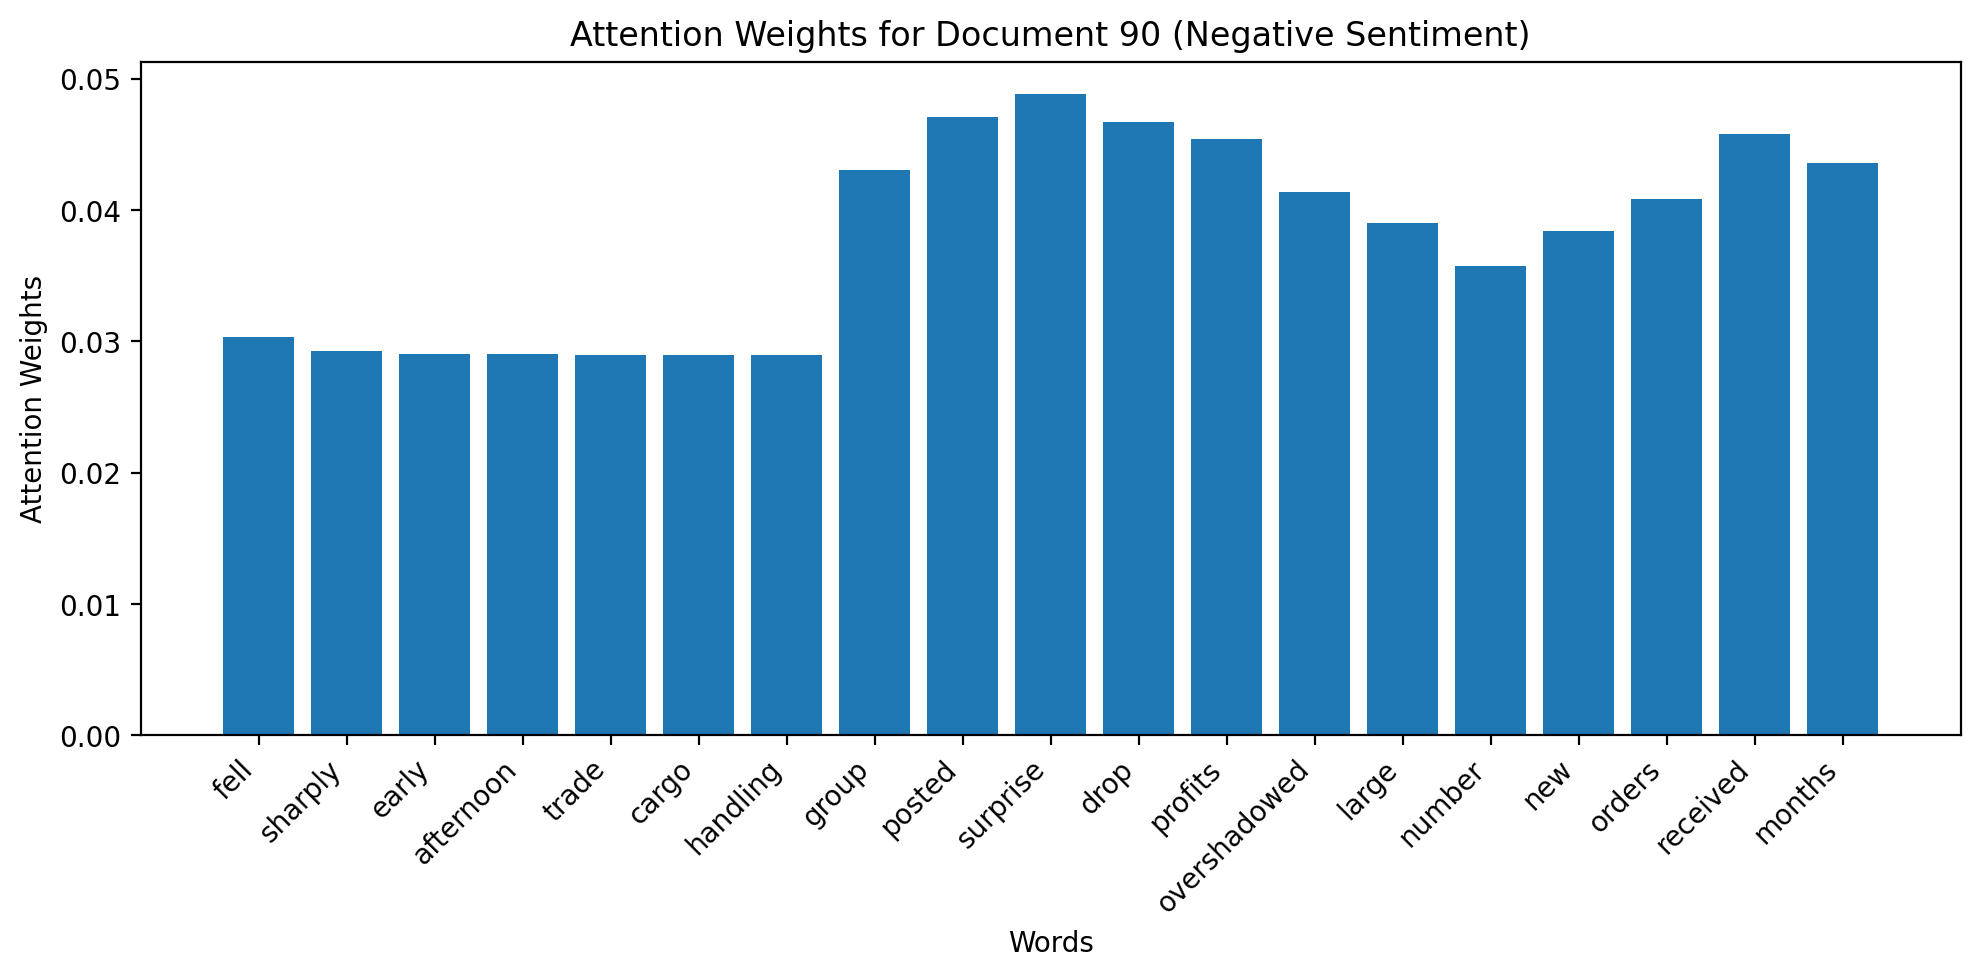

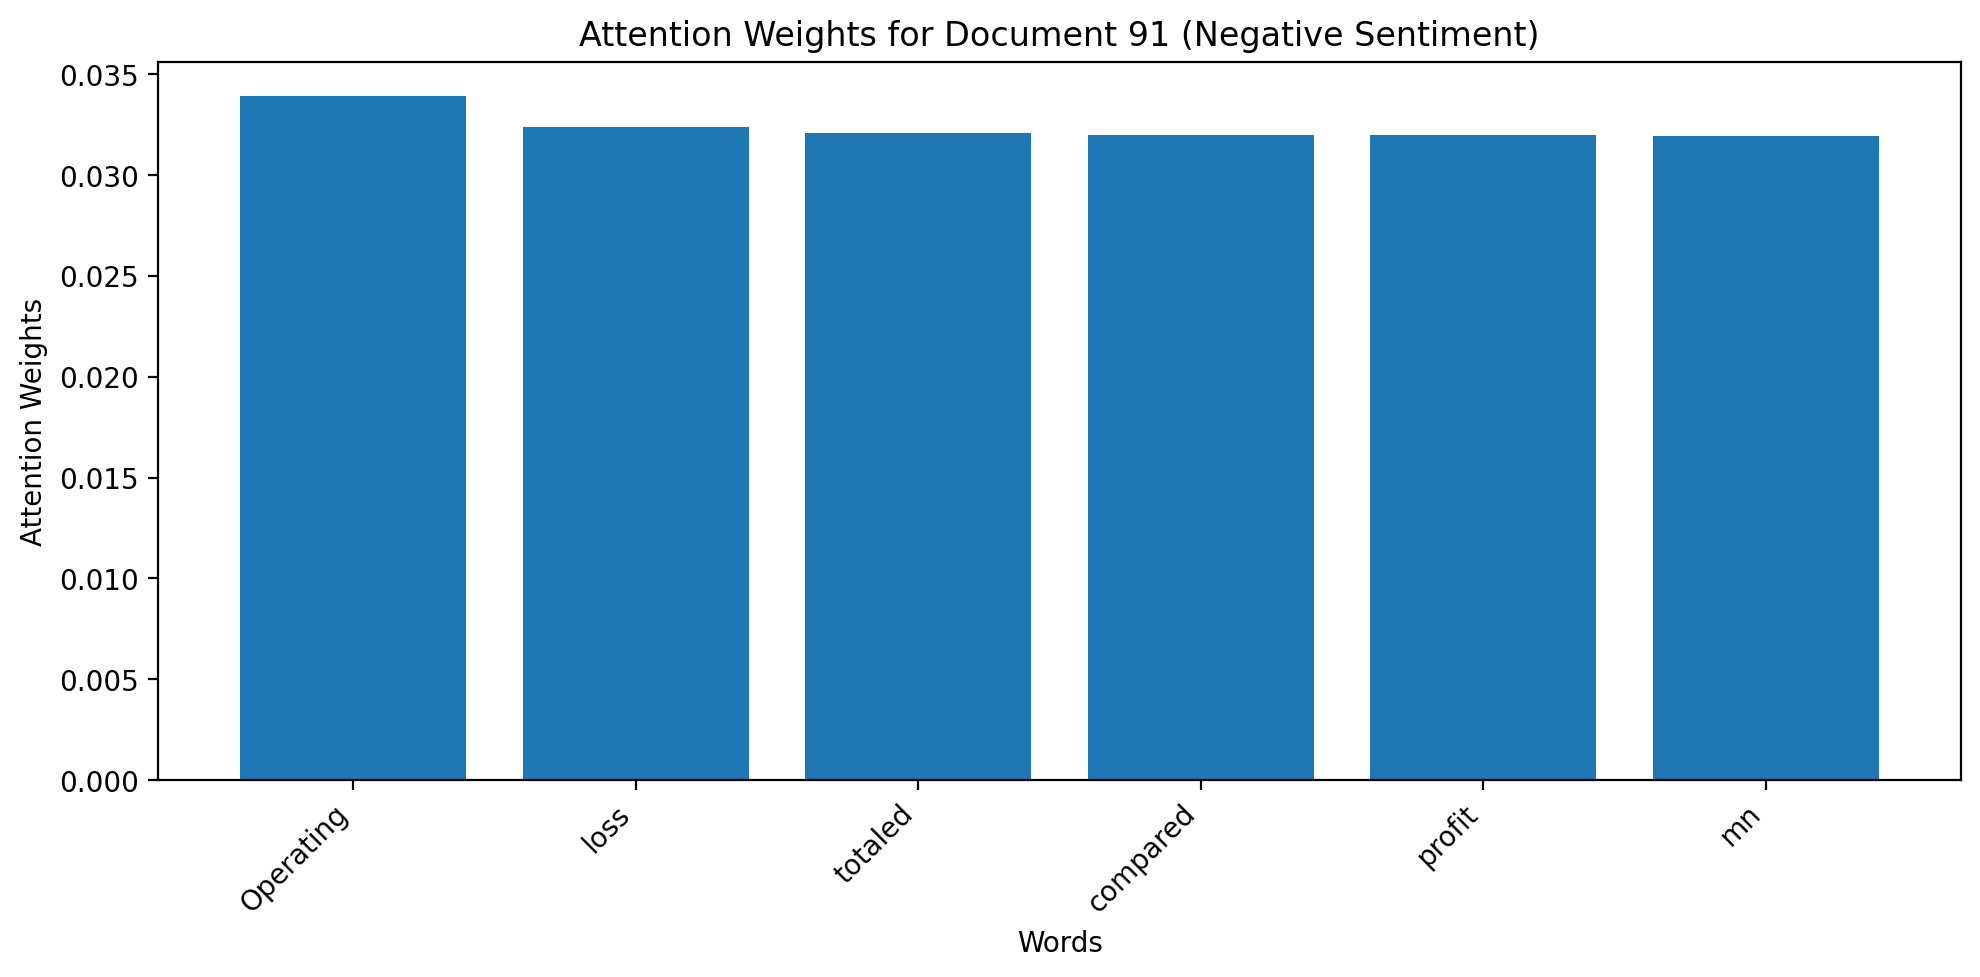

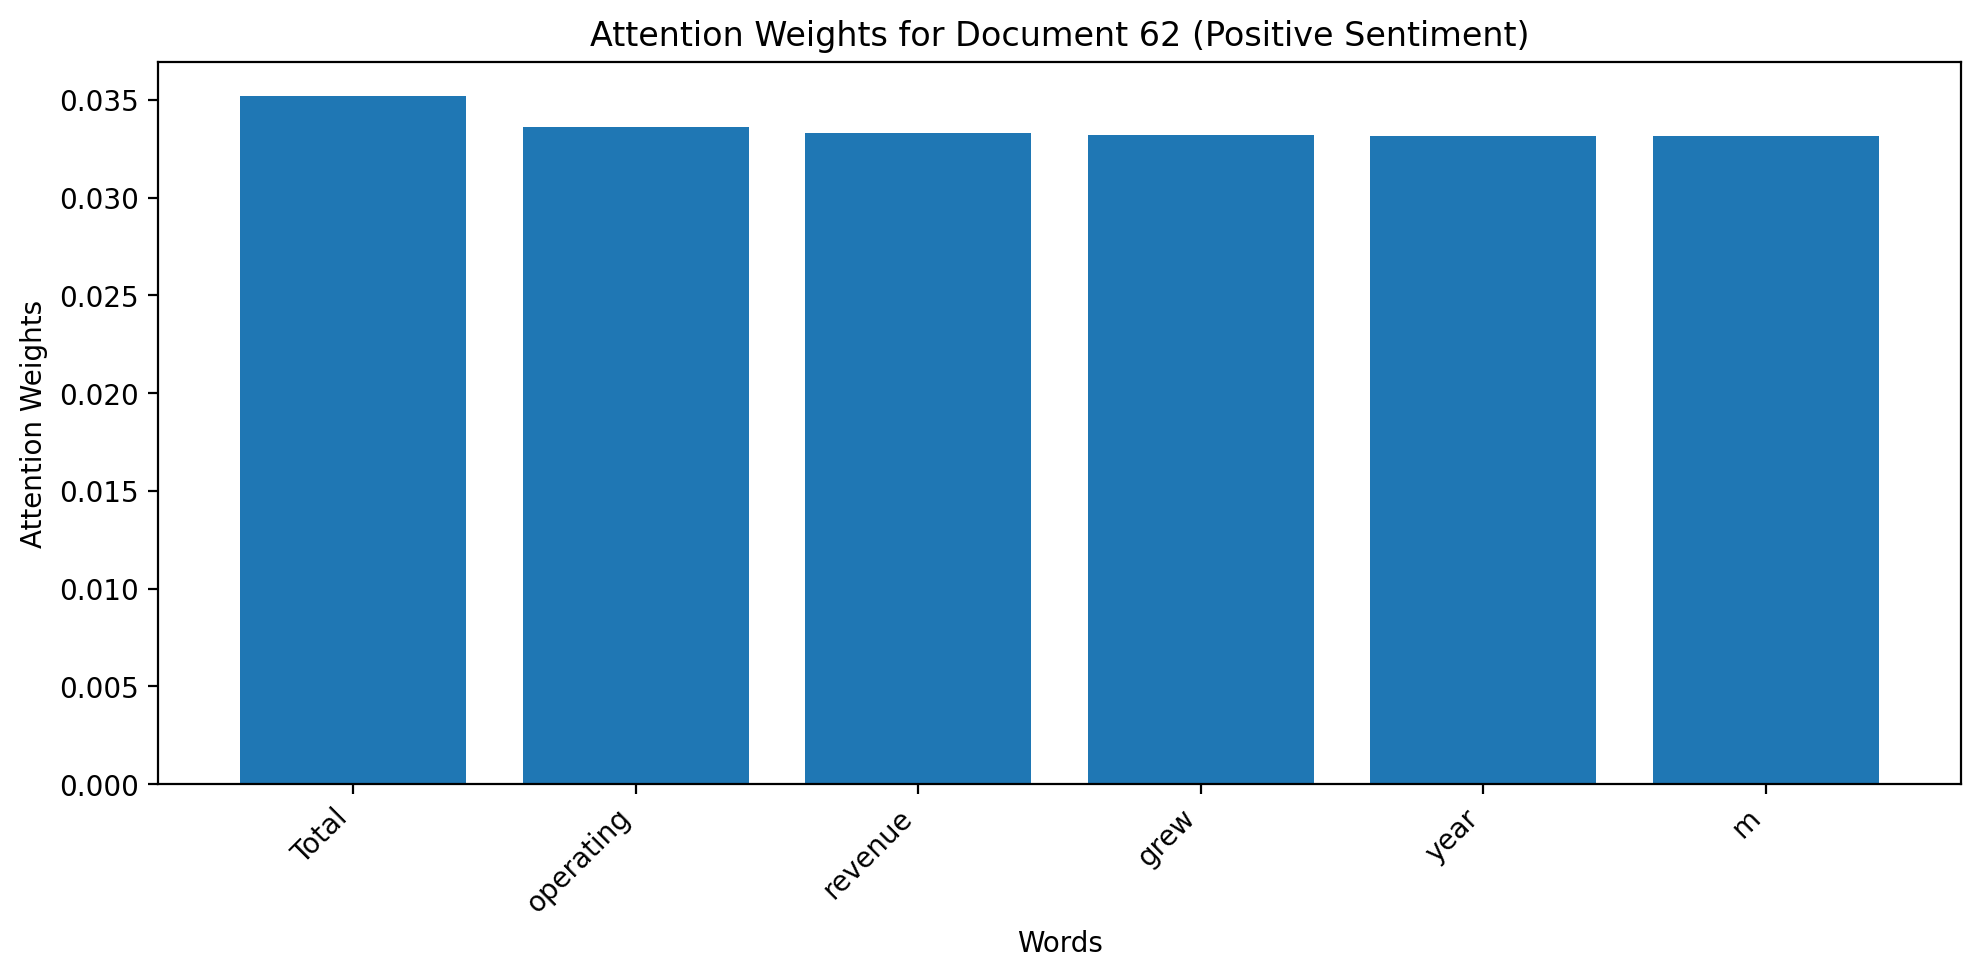

In [ ]:
docs_to_visualize = [docs_to_visualize[70], docs_to_visualize[71], docs_to_visualize[42]]
for doc_data in docs_to_visualize:  # Iterate over the tuples
    doc_idx, words, sentiment = doc_data
    with torch.no_grad():
        # Get the input vector for the document
        x_input = torch.Tensor([[w.vector for w in docs_test[doc_idx]]])  # Input as a batch of size 1
        lengths = [len_test[doc_idx]]

        # Get attention weights from the RNN model
        _, attn_weights = my_RNN.attention(my_RNN.rnn(x_input)[0], torch.stack([my_RNN.rnn(x_input)[0][0, lengths[0] - 1, :]]), (x_input.sum(dim=-1) != 0).float())

        # Get the words from the document
        words = [token.text for token in docs_test[doc_idx] if not token.text == "#"]

        # Plot the attention weights
        plt.figure(figsize=(10, 5))
        plt.bar(words, attn_weights[0, :len(words)].cpu().numpy())
        plt.xlabel("Words")
        plt.ylabel("Attention Weights")
        plt.title(f"Attention Weights for Document {doc_idx} ({sentiment} Sentiment)") # Using sentiment from tuple
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Conclusions
### 1. Data
First, we had to import the data used from the `sentences.txt` file: raw sentences. Then we transformed it using a pretrained NLP model from spacy, specifically the `en_core_web_md` which is a medium size model, sufficient for our case. Using this model we can obtain the embeddings that we will use as the input for our model

### 2. RNN without Attention
Our model without attention is a RNN with LSTM modules that improve performance. Once an entire sequence is processed we receive the context vector that outputs the last word of the sentence.

Then, we input this context into a simple fully connected layer (previously passed through a dropout layer for regularization) and output our result, indicating if the sequence is positve/neutral or negative.

### 3. RNN with Attention
In the second part we train the same RNN with LSTM adding an attention mechanism. This attention mecanism will help the final fully connected layer receive a more broader and better context depending on the sentence we are classifying.

In this case we use an attention mechanism based on: queries and keys, we do not use values.

#### 3.1 Architecture
For this specific case:
- The context of the last word is the query:  
$$ h_\ell = q $$

- All the contexts we receive from the sentence are the keys:  
$$h_0, \dots, h_\ell = H = K $$

- The attention mechanism $a$ is an MLP with 2 layers that receives as input the query $ q $ and the key $ k_j $ for the $j$-th word in the sentence. Our goal is for the MLP to learn the relation between the query and the key.  

- We compute a vector of weights $w$ where:
$$
w_j = a(q, k_j) \quad \forall j = 1, \dots, \ell
$$

- Finally, we normalize these weights using a softmax function, and this is the input we use for our final classifier.

 Here we can find a sketch of how we implemented this process:

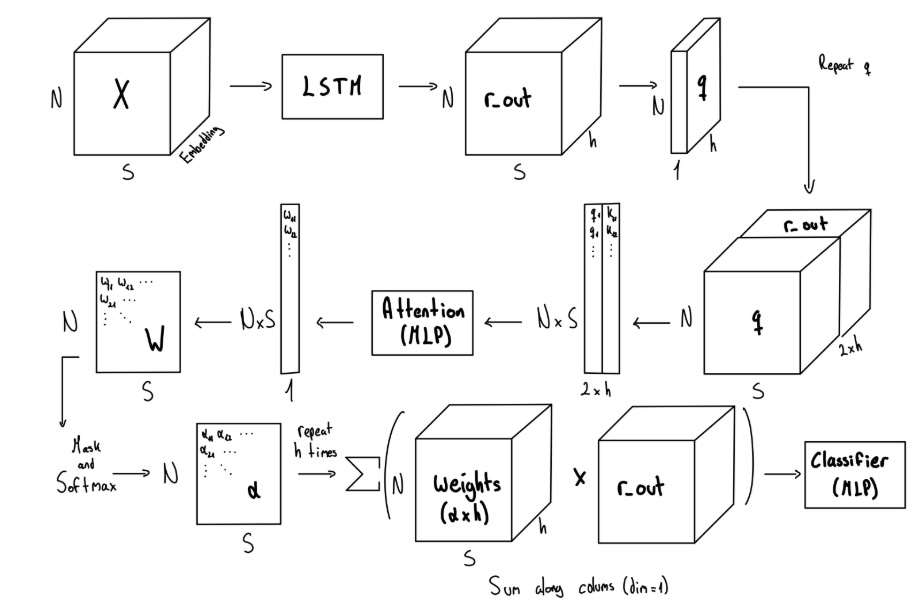


### 4. Visualizing Weights
To better understand the model's decision-making process, we visualized the attention weights over the input text. These weights highlight the most influential words or tokens the model focuses on when determining the sentiment.

Interestingly, in some examples, the attention distribution appeared almost uniform, suggesting that no single word stood out strongly in determining the sentiment. This could be linked to two cases:
- Either where sentiment is spread across the whole text,
- or it's not clear where to focus the attention so it's distributed uniformly.

### 5. Comments
The performance of the model with attention is a lot better than the model without it. Our guess is that while LSTMs remove the problem of vanishing gradients better than regular RNNs, they still struggle with very long-range dependencies - if the relevant information is far from the current timestep, an LSTM might not capture it effectively-, whereas attention connects relevant words or tokens in the input sequence.


